Data processing

In [ ]:
from tqdm import tqdm
import pandas as pd

""" Drugs前處理 """

df_A = pd.read_csv('rawData/all1_1080108_A.csv')
df_A = df_A[['B', 'G']]
df_B = pd.read_csv('rawData/all1_1080108_B.csv')
df_B = df_B[['B', 'F']]
df_A.columns = df_B.columns = ['drug_no', 'drug_name']
df_all = pd.concat([df_A, df_B], ignore_index = True)
df_all = df_all.sort_values(by = 'drug_no')
df_drugs = df_all.drop_duplicates('drug_no')
df_drugs = df_drugs[df_drugs['drug_no'].str.len() == 10] #去掉 YC00004217 1 這種

df_drugs.to_csv('rawData/drugs.csv', index = False)

dfDrugs = pd.read_csv('rawData/drugs.csv')

# 建立no_to_name Dict
no_to_name = {}
for _ in dfDrugs.index:
    no_to_name[dfDrugs['drug_no'][_]] = dfDrugs['drug_name'][_]


""" Dxref前處理 """

dfDxref = pd.read_csv('rawData/DXREF_2008_Archive.csv')

dfDxref.columns = ['ICD9_cm_code', 'ccs_category', 'ccs_category_description', 'code_description']
dfDxref.drop(['code_description'], axis = 1, inplace = True)

# 濾掉空格、斜線
dfDxref['ICD9_cm_code'] = dfDxref['ICD9_cm_code'].str.replace('\'', '').str.replace(' ', '')
dfDxref['ccs_category'] = dfDxref['ccs_category'].str.replace('\'', '').str.replace(' ', '')
dfDxref['ccs_category_description'] = dfDxref['ccs_category_description'].str.replace('\'', '').str.replace(' ', '')

dfDxref['ccs_category'] = dfDxref['ccs_category'].astype(int)

# 濾掉CCS為Ecode的資料
dfDxref = dfDxref[dfDxref['ccs_category'] < 1000]

dfDxref.reset_index(drop = True, inplace = True)

# 建立code_to_ccs Dict
code_to_ccs = {}
for _ in dfDxref.index:
    code_to_ccs[dfDxref['ICD9_cm_code'][_]] = dfDxref['ccs_category'][_]
    
# 建立ccs Dict
dfTmp = dfDxref.drop_duplicates('ccs_category_description')
ccs = {}
for _ in dfTmp.index:
    ccs[dfTmp['ccs_category'][_]] = dfTmp['ccs_category_description'][_]

    
""" DATA前處理 """

dfData = pd.read_csv('rawData/DATA_Hosp_ver.csv')

dfData.columns = ['drug_no', 'ICD9_cm_code']

# 濾掉空格
dfData['drug_no'] = dfData['drug_no'].str.replace(' ', '')
dfData['ICD9_cm_code'] = dfData['ICD9_cm_code'].str.replace(' ', '')

# 濾掉非服用藥的資料
dfData = dfData[dfData['drug_no'].str.len() == 10]

# 濾掉不在DXREF中的資料
dfData = dfData[dfData['ICD9_cm_code'].isin(dfDxref['ICD9_cm_code'])]

dfData.reset_index(drop = True, inplace = True)


""" 整合產出csv """

dfResult = pd.DataFrame(columns = ['ICD-9-CM_CODE', 'CCS_CATEGORY', 'CCS_DESCRIPTION', 'DRUG_NO', 'DRUG_NAME'])

count = 0
with tqdm(desc = '進度', total = len(dfData.index)) as progress_bar:
    for _ in dfData.index:
        col1 = dfData['ICD9_cm_code'][_]
        
        if dfData['ICD9_cm_code'][_] in code_to_ccs:
            col2 = code_to_ccs[dfData['ICD9_cm_code'][_]]
            col3 = ccs[col2]
        else:
            count += 1
            progress_bar.update(1)
            continue
        
        col4 = dfData['drug_no'][_]
        
        if dfData['drug_no'][_] in no_to_name:      
            col5 = no_to_name[dfData['drug_no'][_]]
        else:
            count += 1
            progress_bar.update(1)
            continue
            
        dfResult.loc[_] = [col1, col2, col3, col4, col5]
        count += 1
        progress_bar.update(1)

dfResult.to_csv('afterData/A.csv', index = False)

Caculate #Patients and drop duplicates

In [ ]:
# 算出patients且刪除重複
from tqdm import tqdm
import pandas as pd
import numpy as np

dfInput = pd.read_csv('afterData/A.csv')

dfInput.sort_values(by = ['CCS_CATEGORY', 'DRUG_NO'], inplace = True)

dfInput.drop(['ICD-9-CM_CODE', 'DRUG_NO'], axis = 1, inplace = True)

ndaCcs = dfInput['CCS_DESCRIPTION'].drop_duplicates().values

dfgbInput = dfInput.groupby('CCS_DESCRIPTION')

dfOutput = pd.DataFrame(columns = ['CCS_CATEGORY', 'CCS_DESCRIPTION', 'DRUG_NAME', 'PATIENTS'])

with tqdm(desc = '進度', total = len(ndaCcs)) as progress_bar:
    idx = 0
    for _ in ndaCcs:
        dfGroup = dfgbInput.get_group(_)
        ndaName = dfGroup['DRUG_NAME'].drop_duplicates().values

        for __ in ndaName:
            count = list(dfGroup['DRUG_NAME']).count(__)
            dfTmp = dfGroup[dfGroup['DRUG_NAME'] == __].drop_duplicates('DRUG_NAME')
            dfOutput.loc[idx] = [dfTmp['CCS_CATEGORY'].values[0], dfTmp['CCS_DESCRIPTION'].values[0], dfTmp['DRUG_NAME'].values[0], count]
            
            # 刪除已經算過的
            dfGroup = dfGroup[dfGroup['DRUG_NAME'] != __]
            
            idx  += 1
            
        progress_bar.update(1)

dfOutput.to_csv('afterData/B.csv', index = False)

# dfgbInput.size().sort_values()

Select five diseases which have top five high patients to clustering

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def execute(ccs_type):
    df_pp = df[df['CCS_DESCRIPTION'] == ccs_type]
    df_pp = df_pp.sort_values(by=['PATIENTS'], ascending=False)
    df_pp = df_pp.iloc[:20]
    df_pp.to_csv('result/' + ccs_type.replace('/', '¥').replace(':', '') + '.csv', index=False)
    

df = pd.read_csv('afterData/B.csv')
# df_dd = df.drop_duplicates('ccs_description')
ccs_types = ['DiabMelnoc', 'DiabMelw/cm', 'HTN', 'Coronathero', 'Chrrenfail']

for t in ccs_types:
    print(t)
    execute(t)



DiabMelnoc
DiabMelw/cm
HTN
Coronathero
Chrrenfail


Hierarchical Clustering

進度: 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


'exit(0)'

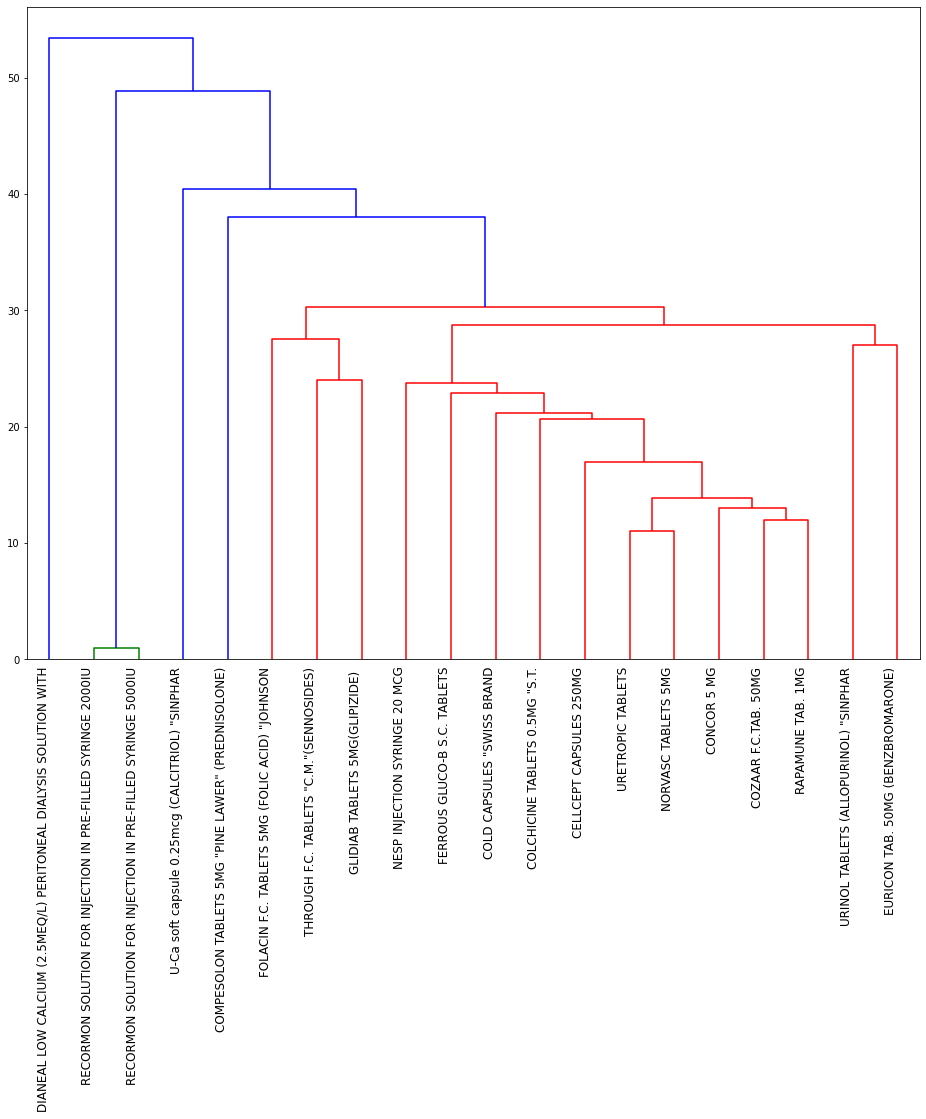

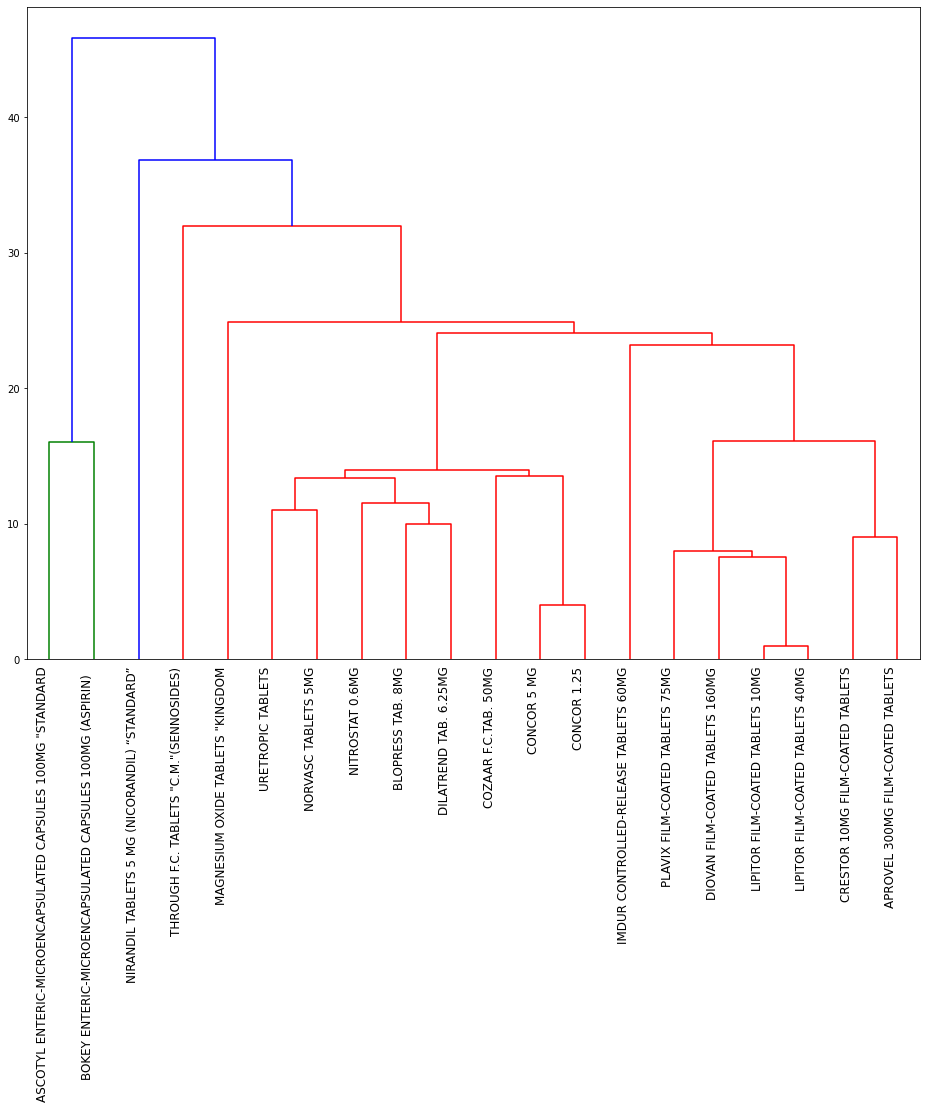

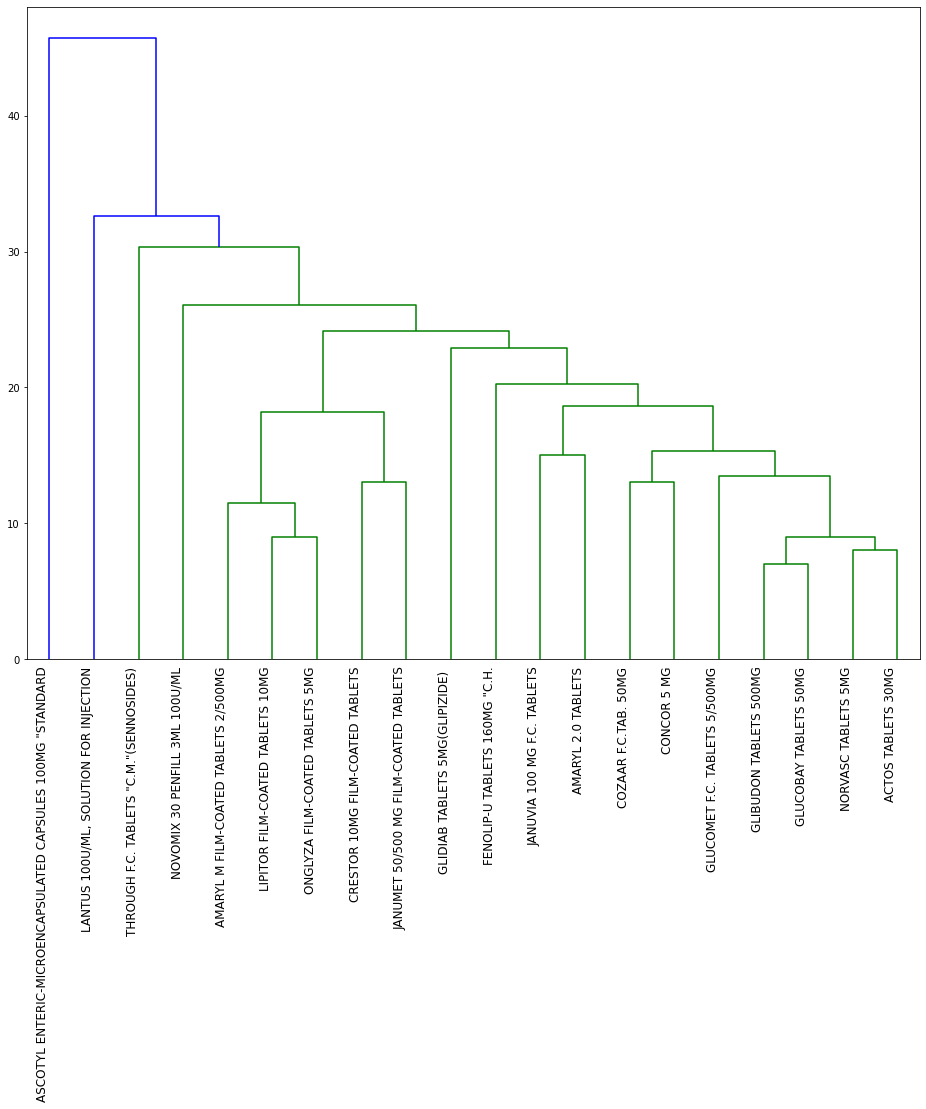

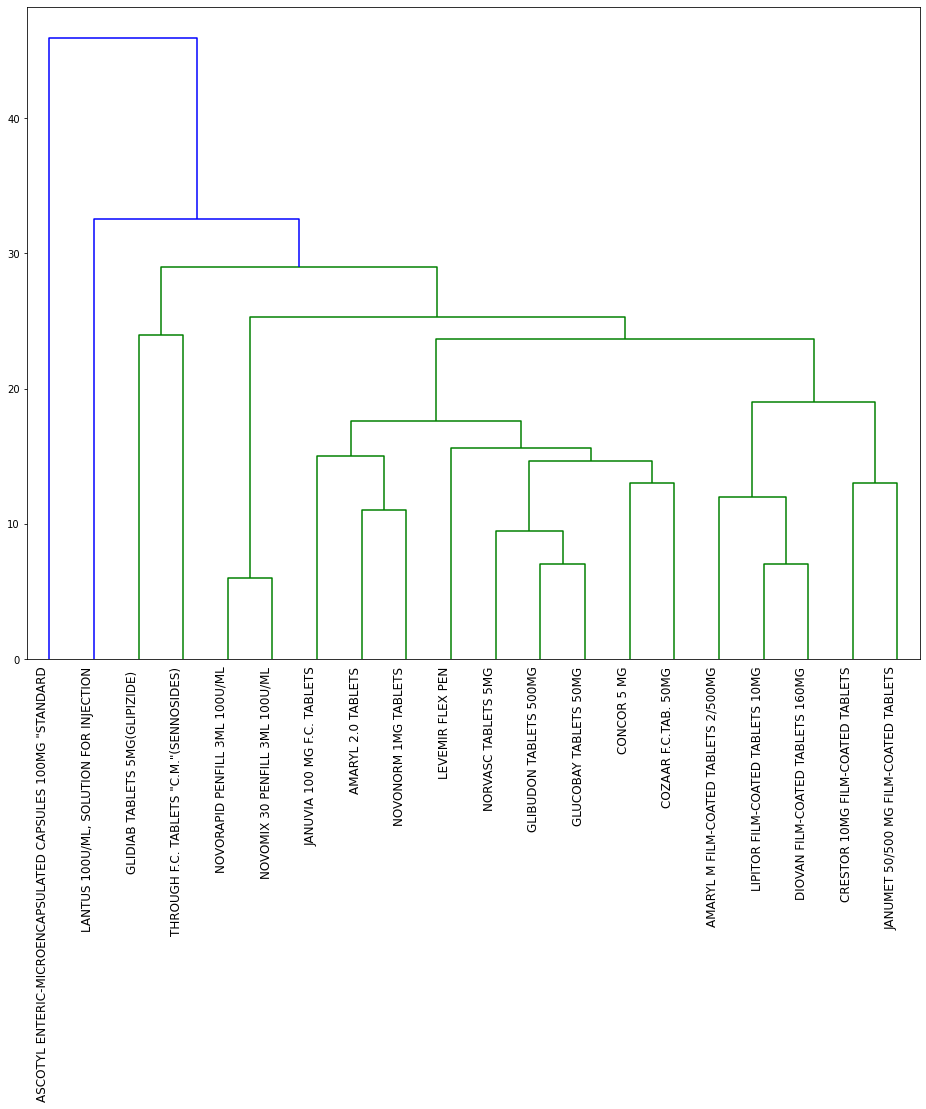

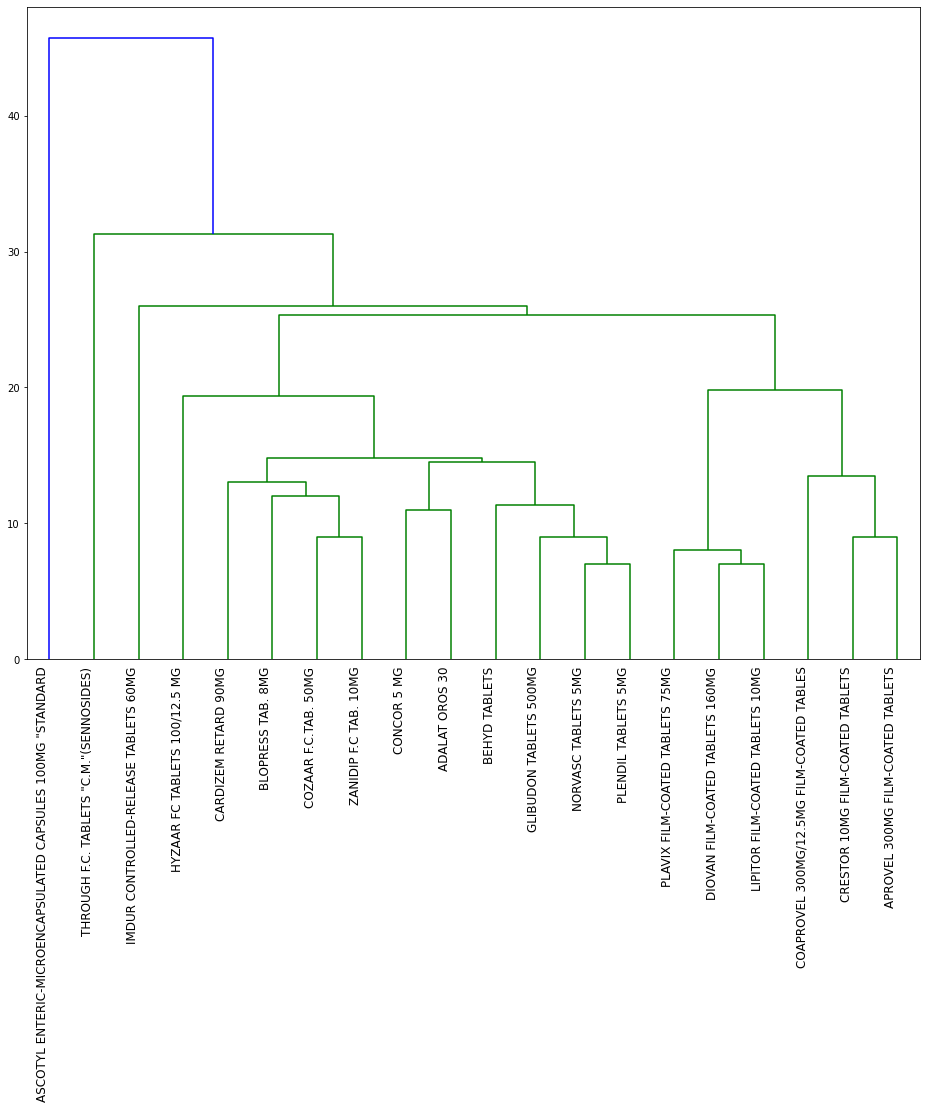

In [21]:
# 產出HAC分群結果與樹狀圖
from matplotlib import pyplot as plt
from tqdm import tqdm
import scipy.cluster.hierarchy as sch
import pandas as pd
import numpy as np
import distance as dt

# dfInput = pd.read_csv('C.csv')
# ndaCategorys = dfInput['CCS_DESCRIPTION'].drop_duplicates().values

ndaCategorys = np.array(['Chrrenfail', 'Coronathero', 'DiabMelw/cm', 'DiabMelnoc', 'HTN'])

def HAC_with_Levenshtein_distance(_cat):

    df_ = dfInput.loc[dfInput['CCS_DESCRIPTION'] == _cat]
    ndaDrugsName = df_['DRUG_NAME'].values
    
    distance_matrix = []
    
    for _ in range(len(ndaDrugsName)):
        for __ in range(_ + 1, len(ndaDrugsName)):
            distance_matrix.append(float(dt.levenshtein(ndaDrugsName[_], ndaDrugsName[__])))

    if len(ndaDrugsName) == 1:
        dfOutput =  pd.DataFrame(data = {'1': ndaDrugsName})
        
    else:
        Z = sch.linkage(np.asarray(distance_matrix), method = 'average')
 
        plt.figure(figsize=(16, 12)) # 畫布長寬
        sch.dendrogram(Z, leaf_rotation=90.) # 樹狀圖設定
        
        locs, labels = plt.xticks()
        new_labels = []
        for l in range(len(labels)):
            new_labels.append(ndaDrugsName[int(labels[l].get_text())])
            
        plt.xticks(locs, new_labels, rotation=90, horizontalalignment='right')
        plt.savefig('plot/' + _cat.replace('/', '／').replace(':', '') + '.png')

        fc = sch.fcluster(Z, t = 0.1, criterion = 'inconsistent')

        dictTmp = {}

        for _ in range(len(fc)):
            if fc[_] not in dictTmp:
                dictTmp[fc[_]] = []
            dictTmp[fc[_]].append(ndaDrugsName[_])

        dfOutput = pd.DataFrame.from_dict(dictTmp, orient = 'index').T
        dfOutput.sort_index(axis = 1, inplace = True)

    dfOutput.to_csv('plot/' + _cat.replace('/', '／').replace(':', '') + '.csv', index = False)


with tqdm(desc = '進度', total = len(ndaCategorys)) as progress_bar:
    for cat in ndaCategorys:
        dfInput = pd.read_csv('result/' + cat.replace('/', '¥').replace(':', '') + '.csv')
        HAC_with_Levenshtein_distance(cat)
        progress_bar.update(1)

'exit(0)'